# Modelling

In [1]:
# Load libraries
import pickle
import time
import os
import numpy as np
import pandas as pd
from sklearn import metrics

# For modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# notebook settings
%matplotlib inline
pd.options.display.max_columns = None
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


# Load data

In [3]:
water_pump_data = pd.read_csv('../data/processed/water_pump_dataset_encoded.csv')

In [4]:
# split into features and target
feature_cols = list(water_pump_data.columns)
feature_cols.remove('status_group')
features = water_pump_data[feature_cols]
target = water_pump_data['status_group']

In [5]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)

# Select models

- Decision trees use the whole dataset to create a decision process for each feature.
- Random forests or random decision forests is an ensemble learning method that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. 
- XGBoost: Gradient boosting is a machine learning technique that uses a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees. 
- K-nearest neighbours looks at k data points nearest to the current one and goes with the majority classification.


# Train models

In [6]:
# Train models

classifiers = [
    ['decision_tree', DecisionTreeClassifier(splitter='best', random_state=8)],
    ['random_forest',RandomForestClassifier(n_estimators= 500, n_jobs=-1, random_state=8)],
    ['k_nearest_neighbors',KNeighborsClassifier(n_neighbors=10)],
    ['xgboost', XGBClassifier(objective='multi:softmax', random_state=8)],
]


f1_scores = []
accuracy_scores = []
training_times = []
testing_times = []

for classifier in classifiers:
    print('='*80)
    name, clf = classifier[0], classifier[1]
    print(f'Model: {name}')
    print('-'* 80)
    
    start_time_train = time.time() 
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time_train
    training_times.append(training_time)
    
    start_time_test= time.time() 
    y_pred = clf.predict(X_test)
    report = metrics.classification_report(y_test,y_pred, output_dict=True)
    test_time = time.time()-start_time_test
    testing_times.append(test_time)
    print(metrics.classification_report(y_test, y_pred))
    f1_scores.append(report['macro avg']['f1-score'])
    accuracy_scores.append(report['accuracy'])
    

Model: decision_tree
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      8056
           1       0.77      0.76      0.77      5727
           2       0.38      0.37      0.38      1067

    accuracy                           0.76     14850
   macro avg       0.65      0.65      0.65     14850
weighted avg       0.76      0.76      0.76     14850

Model: random_forest
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      8056
           1       0.85      0.79      0.82      5727
           2       0.51      0.34      0.41      1067

    accuracy                           0.81     14850
   macro avg       0.72      0.67      0.69     14850
weighted avg       0.80      0.81      0.80     14850

Model: k_nearest_neighbors
-------

In [7]:
results_dict = {'method': [classifier[0] for classifier in classifiers],
               'f1_scores': f1_scores,
               'accuracy_scores': accuracy_scores,
               'training_times': training_times,
               'testing_times': testing_times}

results = pd.DataFrame(results_dict)


In [8]:
results

,method,f1_scores,accuracy_scores,training_times,testing_times
0,decision_tree,0.648498,0.758653,1.135886,0.029310
1,random_forest,0.690705,0.810707,7.504082,0.318714
2,k_nearest_neighbors,0.560392,0.703906,0.047530,1.697059
3,xgboost,0.652894,0.795488,17.125959,0.047601


Text(0.5, 0, 'seconds')

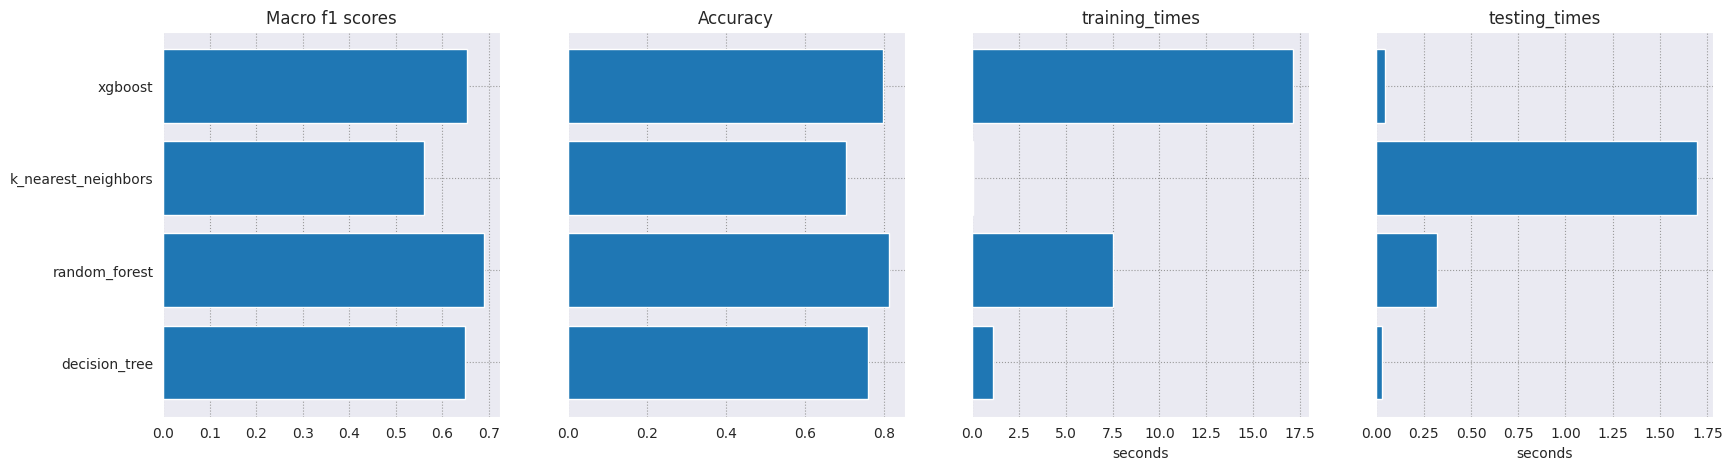

In [9]:
# Create subplots with 2 columns and 1 row
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)

axs[0].barh(results['method'], results['f1_scores'])
axs[0].set_title('Macro f1 scores')

axs[1].barh(results['method'], results['accuracy_scores'])
axs[1].set_title('Accuracy')

axs[2].barh(results['method'], results['training_times'])
axs[2].set_title('training_times')
axs[2].set_xlabel('seconds')

axs[3].barh(results['method'], results['testing_times'])
axs[3].set_title('testing_times')
axs[3].set_xlabel('seconds')



Reporting Macro F1 scores, since that results in bigger penalisation when the model does not perform well on the minority class. Since we have class imbalance.

# Hyperparameter tuning


For the best performing model which is the random forest classifier.

## Best base model

In [10]:
rf_base = RandomForestClassifier(n_estimators = 500, random_state = 8)
rf_base.fit(X_train, y_train)
report = metrics.classification_report(y_test, rf_base.predict(X_test), output_dict=True)



In [11]:
print(metrics.classification_report(y_test, rf_base.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      8056
           1       0.85      0.79      0.82      5727
           2       0.51      0.34      0.41      1067

    accuracy                           0.81     14850
   macro avg       0.72      0.67      0.69     14850
weighted avg       0.80      0.81      0.80     14850



In [12]:
# Create models folder

if not os.path.exists('../models'):
    os.makedirs(path)

# save model
filename = '../models/random_forest_base_v1.sav'
pickle.dump(rf_base, open(filename, 'wb'))

In [13]:
def plot_feature_importance(model, trainings_data, threshold=20):
    
    feature_importance =  np.array(model.feature_importances_)
    col_names = np.array(trainings_data.columns)
    
    data={'feature_names':col_names,'feature_importance':feature_importance}
    feature_importance_df = pd.DataFrame(data)

    feature_importance_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    top_feature_importance = feature_importance_df.head(threshold)

    plt.figure(figsize=(10,10))
    sns.barplot(x=top_feature_importance['feature_importance'], y=top_feature_importance['feature_names'])
    plt.title(f'Top {threshold} categories feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')

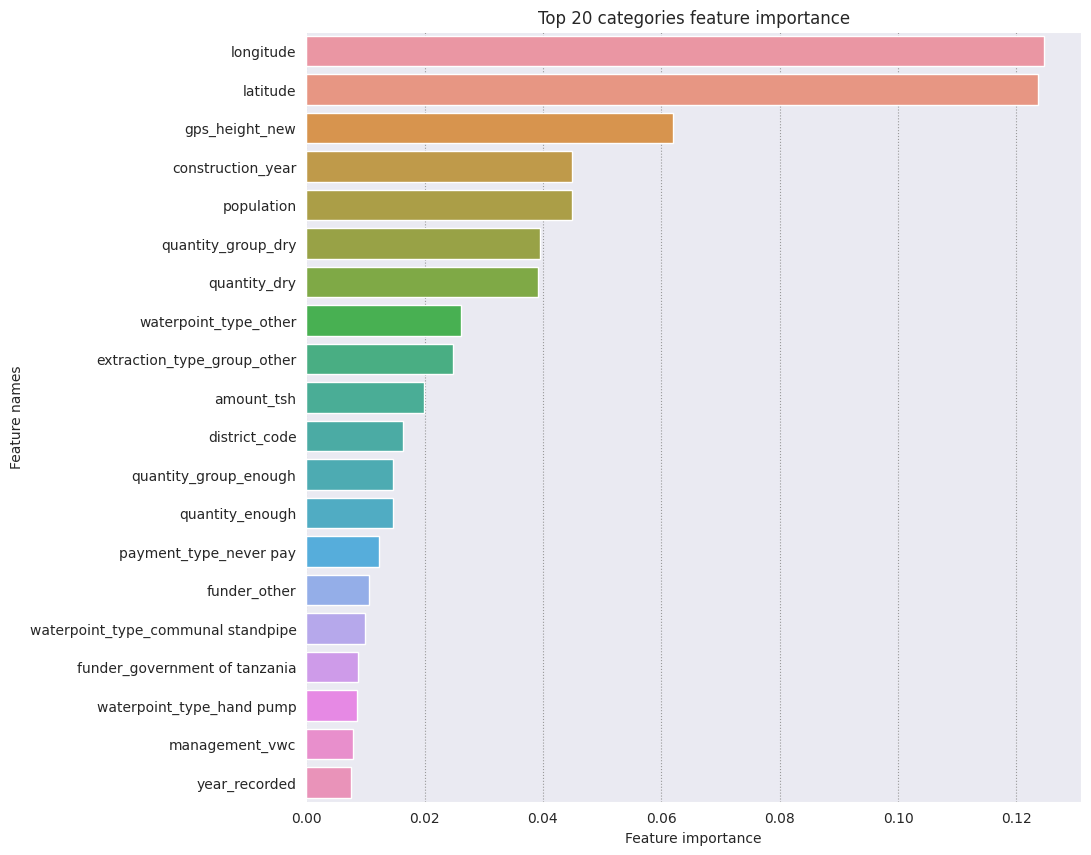

In [14]:
plot_feature_importance(rf_base, X_train, threshold=20)


# Random search tuning

In [15]:
search_grid = {
    'bootstrap': [True, False],
     'max_depth': [40, 50, 60, 70, 80, 90, 100, None],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400,600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [16]:
# Create model for tuning
random_forest_classifier = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_tuned = RandomizedSearchCV(estimator = random_forest_classifier, param_distributions = search_grid, n_iter = 50, cv = 3, verbose=2, random_state=8, n_jobs = 8)

# Fit the random search model
rf_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.5min


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, max_depth=100, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.7min
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_estimators=600; total time=  58.6s
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time= 1.8min
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; total time= 2.1min
[CV] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; total time= 1.7min
[CV] END bootstrap=True, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time= 2.0min
[CV] END bootstrap=False, max_depth=None, min_sample

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=8,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [40, 50, 60, 70, 80, 90,
                                                      100, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=8, verbose=2)

In [22]:
# show best params
rf_tuned.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 50,
 'bootstrap': False}

In [23]:
rf_tuned.best_estimator_


RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_leaf=2,
                       n_estimators=600)

In [24]:
print(metrics.classification_report(y_test, rf_tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      8056
           1       0.86      0.77      0.81      5727
           2       0.63      0.27      0.37      1067

    accuracy                           0.81     14850
   macro avg       0.76      0.65      0.68     14850
weighted avg       0.81      0.81      0.80     14850



In [20]:
# save model, not much better than base_model. not saving
# filename = '../models/random_forest_tuned_v1.sav'
# pickle.dump(rf_tuned, open(filename, 'wb'))

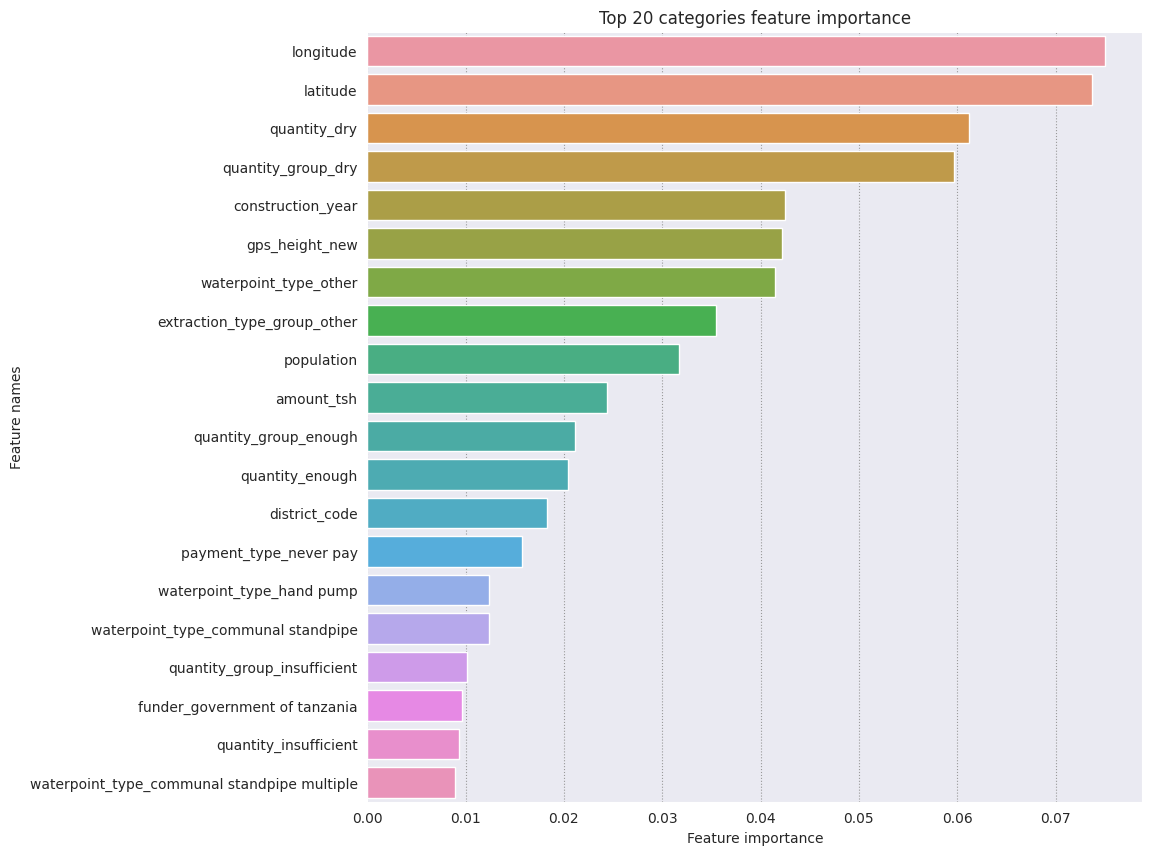

In [27]:
plot_feature_importance(rf_tuned.best_estimator_, X_train, threshold=20)
